On travaille sur le Dataset regularite-mensuelle-tgv-aqst qui rend compte de tous les retards moyens mensuels des trajets en TGV proposé par le SCNF depuis Janvier 2018.

In [2]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import math
import numpy as np
import re
import matplotlib.pyplot as plt

In [3]:
url_retards ='https://ressources.data.sncf.com/api/v2/catalog/datasets/regularite-mensuelle-tgv-aqst/exports/json?limit=-1&offset=0&timezone=UTC'
retards = requests.get(url_retards)
wb_retards = retards.json()

df_retards = pd.DataFrame(wb_retards)
df_retards.head(2)

,date,service,gare_depart,gare_arrivee,duree_moyenne,nb_train_prevu,nb_annulation,commentaire_annulation,nb_train_depart_retard,retard_moyen_depart,...,nb_train_retard_sup_15,retard_moyen_trains_retard_sup15,nb_train_retard_sup_30,nb_train_retard_sup_60,prct_cause_externe,prct_cause_infra,prct_cause_gestion_trafic,prct_cause_materiel_roulant,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs
0,2018-01,National,LE MANS,PARIS MONTPARNASSE,56,406,1,None,213,8.479969,...,32,5.363539,9,4,20.000000,35.000000,16.666667,16.666667,8.333333,3.333333
1,2018-01,National,NANTES,PARIS MONTPARNASSE,128,525,3,None,193,7.294991,...,56,7.225734,29,11,37.333333,26.666667,21.333333,4.000000,9.333333,1.333333


On commence par réorganiser notre Dataset. On divise la colonne 'date' en deux colonnes 'annee' et 'mois'. Puis on crée 2 nouvelles colonnes qui regarde le pourcentage de trains avec un depart au retard et le pourcentage de trains annulés.

In [4]:
df_retards['prct_nb_train_depart_retard'] = df_retards['nb_train_depart_retard']/df_retards['nb_train_prevu']*100
df_retards['prct_nb_annulation'] = df_retards['nb_annulation']/df_retards['nb_train_prevu']*100
df_retards[['annee','mois']]=df_retards.date.str.split('-',expand=True)
df_retards.head(2)

,date,service,gare_depart,gare_arrivee,duree_moyenne,nb_train_prevu,nb_annulation,commentaire_annulation,nb_train_depart_retard,retard_moyen_depart,...,prct_cause_externe,prct_cause_infra,prct_cause_gestion_trafic,prct_cause_materiel_roulant,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs,prct_nb_train_depart_retard,prct_nb_annulation,annee,mois
0,2018-01,National,LE MANS,PARIS MONTPARNASSE,56,406,1,None,213,8.479969,...,20.000000,35.000000,16.666667,16.666667,8.333333,3.333333,52.463054,0.246305,2018,01
1,2018-01,National,NANTES,PARIS MONTPARNASSE,128,525,3,None,193,7.294991,...,37.333333,26.666667,21.333333,4.000000,9.333333,1.333333,36.761905,0.571429,2018,01


On remarque que les colonnes des commentaires sont vides ou presque et ne nous interessent pas donc on peut les retirer. On retire également la colonne date étant donné que l'on vient juste de la diviser en deux colonnes annee et mois.

In [5]:
df_retards = df_retards.drop('commentaire_annulation', axis = 1)
df_retards = df_retards.drop('commentaire_retards_depart', axis = 1)
df_retards = df_retards.drop('commentaires_retard_arrivee', axis = 1)
df_retards['annee'] = pd.to_numeric(df_retards['annee'])
df_retards['mois'] = pd.to_numeric(df_retards['mois'])
df_retards.groupby(['date'])
df_retards

,date,service,gare_depart,gare_arrivee,duree_moyenne,nb_train_prevu,nb_annulation,nb_train_depart_retard,retard_moyen_depart,retard_moyen_tous_trains_depart,...,prct_cause_externe,prct_cause_infra,prct_cause_gestion_trafic,prct_cause_materiel_roulant,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs,prct_nb_train_depart_retard,prct_nb_annulation,annee,mois
0,2018-01,National,LE MANS,PARIS MONTPARNASSE,56,406,1,213,8.479969,4.567119,...,20.000000,35.000000,16.666667,16.666667,8.333333,3.333333,52.463054,0.246305,2018,1
1,2018-01,National,NANTES,PARIS MONTPARNASSE,128,525,3,193,7.294991,2.720211,...,37.333333,26.666667,21.333333,4.000000,9.333333,1.333333,36.761905,0.571429,2018,1
2,2018-01,National,PARIS MONTPARNASSE,ANGERS SAINT LAUD,90,385,3,49,8.362585,0.730105,...,21.428571,23.809524,21.428571,23.809524,9.523810,0.000000,12.727273,0.779221,2018,1
3,2018-01,National,PARIS MONTPARNASSE,QUIMPER,220,248,1,37,9.501351,1.003981,...,26.923077,38.461538,15.384615,19.230769,0.000000,0.000000,14.919355,0.403226,2018,1
4,2018-01,National,POITIERS,PARIS MONTPARNASSE,94,472,4,224,6.784673,3.229701,...,15.789474,45.614035,19.298246,15.789474,1.754386,1.754386,47.457627,0.847458,2018,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6933,2022-08,National,PARIS MONTPARNASSE,ST PIERRE DES CORPS,62,509,0,53,10.325786,0.677472,...,2.040816,10.204082,26.530612,42.857143,6.122449,12.244898,10.412574,0.000000,2022,8
6934,2022-08,National,PARIS MONTPARNASSE,TOURS,74,167,0,16,12.529167,0.835529,...,0.000000,8.333333,16.666667,50.000000,8.333333,16.666667,9.580838,0.000000,2022,8
6935,2022-08,National,SAINT ETIENNE CHATEAUCREUX,PARIS LYON,169,119,0,34,4.072549,1.626754,...,28.571429,9.523810,28.571429,23.809524,0.000000,9.523810,28.571429,0.000000,2022,8
6936,2022-08,National,STRASBOURG,NANTES,319,58,0,10,3.608333,0.614368,...,28.571429,42.857143,14.285714,0.000000,0.000000,14.285714,17.241379,0.000000,2022,8


In [6]:
df_retards.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6938 entries, 0 to 6937
Data columns (total 27 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   date                                  6938 non-null   object 
 1   service                               6938 non-null   object 
 2   gare_depart                           6938 non-null   object 
 3   gare_arrivee                          6938 non-null   object 
 4   duree_moyenne                         6938 non-null   int64  
 5   nb_train_prevu                        6938 non-null   int64  
 6   nb_annulation                         6938 non-null   int64  
 7   nb_train_depart_retard                6938 non-null   int64  
 8   retard_moyen_depart                   6938 non-null   float64
 9   retard_moyen_tous_trains_depart       6938 non-null   float64
 10  nb_train_retard_arrivee               6938 non-null   int64  
 11  retard_moyen_arri

Les données restantes sont presques toutes complètes et on peut commencer à les analyser. On peut commencer à regarder le taux de retard par mois selon les années observées.

In [20]:
df_retards_2018 = df_retards.loc[(df_retards['annee'] == 2018),['prct_nb_train_depart_retard','mois']]
X_2018 = []
for i in range(12):
    df = df_retards_2018.loc[(df_retards_2018['mois'] == i+1),['prct_nb_train_depart_retard']]
    x = np.mean(df['prct_nb_train_depart_retard'])
    X_2018.append(x)          

In [21]:
df_retards_2019 = df_retards.loc[(df_retards['annee'] == 2019),['prct_nb_train_depart_retard','mois']]
X_2019 = []
for i in range(12):
    df = df_retards_2019.loc[(df_retards_2019['mois'] == i+1),['prct_nb_train_depart_retard']]
    x = np.mean(df['prct_nb_train_depart_retard'])
    X_2019.append(x)          

In [22]:
df_retards_2020 = df_retards.loc[(df_retards['annee'] == 2020),['prct_nb_train_depart_retard','mois']]
X_2020 = []
for i in range(12):
    df = df_retards_2020.loc[(df_retards_2020['mois'] == i+1),['prct_nb_train_depart_retard']]
    x = np.mean(df['prct_nb_train_depart_retard'])
    X_2020.append(x)          

In [23]:
df_retards_2021 = df_retards.loc[(df_retards['annee'] == 2021),['prct_nb_train_depart_retard','mois']]
X_2021 = []
for i in range(12):
    df = df_retards_2021.loc[(df_retards_2021['mois'] == i+1),['prct_nb_train_depart_retard']]
    x = np.mean(df['prct_nb_train_depart_retard'])
    X_2021.append(x)          

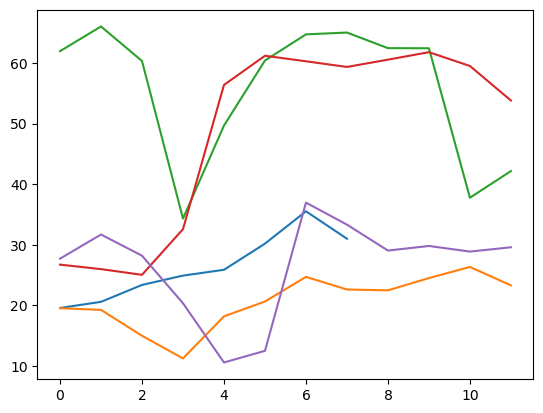

In [26]:
df_retards_2022 = df_retards.loc[(df_retards['annee'] == 2022),['prct_nb_train_depart_retard','mois']]
X_2022 = []
for i in range(8):
    df = df_retards_2022.loc[(df_retards_2022['mois'] == i+1),['prct_nb_train_depart_retard']]
    x = np.mean(df['prct_nb_train_depart_retard'])
    X_2022.append(x)          
plt.plot(X_2022)
plt.plot(X_2021)
plt.plot(X_2020)
plt.plot(X_2019)
plt.plot(X_2018)